In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Lecture 20

## Birth weights

In [2]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = baby.select('Birth Weight', 'Maternal Smoker')
smoking_and_birthweight

Birth Weight,Maternal Smoker
120,False
113,False
128,True
108,True
136,False
138,False
132,False
120,False
143,True
140,False


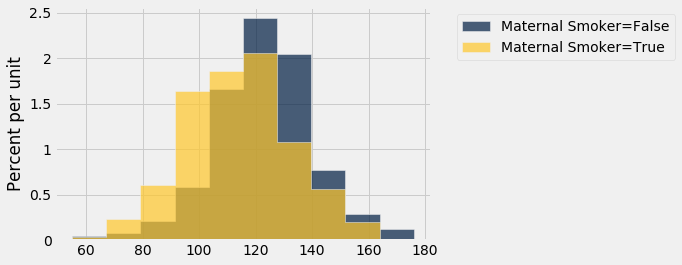

In [4]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [5]:
def diff_between_group_means(tbl):
    means = tbl.group('Maternal Smoker', np.average)
    return means.column(1).item(0) - means.column(1).item(1)

In [6]:
observed_diff = diff_between_group_means(smoking_and_birthweight)
observed_diff

9.266142572024918

In [7]:
# PLAN:

# Shuffle birth weights

# Assign some to group A and some to group B

# Find difference between averages of the two groups (statistic)

# Repeat

In [8]:
weights = smoking_and_birthweight.select('Birth Weight')
weights

Birth Weight
120
113
128
108
136
138
132
120
143
140


In [9]:
smoking = smoking_and_birthweight.select('Maternal Smoker')
smoking

Maternal Smoker
False
False
True
True
False
False
False
False
True
False


In [10]:
# Shuffle birth weights
weights = smoking_and_birthweight.select('Birth Weight')

In [11]:
# Shuffle birth weights
shuffled_weights = weights.sample(with_replacement=False).column(0)
shuffled_weights

array([100,  85, 103, ...,  93, 105, 104])

In [12]:
# Assign some to group A and some to group B
simulated = smoking.with_column('Shuffled weights', shuffled_weights)
simulated

Maternal Smoker,Shuffled weights
False,100
False,85
True,103
True,128
False,127
False,125
False,126
False,130
True,102
False,55


In [13]:
# Find difference between averages of the two groups (statistic)
simulated_diff = diff_between_group_means(simulated)
simulated_diff

0.3623657388363313

In [14]:
# Repeat
diffs = make_array()
for i in np.arange(2000):
    shuffled_weights = weights.sample(with_replacement=False).column(0)
    simulated = smoking.with_column('Shuffled weights', shuffled_weights)
    diff = diff_between_group_means(simulated)
    diffs = np.append(diffs, diff)

diffs

array([ 0.17992596, -0.49617441,  0.12984445, ...,  0.80236757,
        1.20659689, -0.37097064])

## Analyzing RCTs ##

In [15]:
bta = Table.read_table('bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [16]:
bta = Table.read_table('bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [17]:
bta.group('Group', sum)

Group,Result sum
Control,2
Treatment,9


In [18]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [19]:
observed_outcomes = Table.read_table('observed_outcomes.csv')
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


In [20]:
bta.group('Group', np.average).column(1)

array([ 0.125,  0.6  ])

In [21]:
abs(0.125 - 0.6)

0.475

In [22]:
def distance_between_group_proportions(tbl):
    proportions = tbl.group('Group', np.average).column(1)
    return abs(proportions.item(1) - proportions.item(0))

In [23]:
observed_distance = distance_between_group_proportions(bta)
observed_distance

0.475

In [24]:
labels = bta.select('Group')
results = bta.select('Result')

In [25]:
# Repeat
distances = make_array()
for i in np.arange(2000):
    shuffled_results = results.sample(with_replacement=False).column(0)
    simulated = labels.with_column('Shuffled results', shuffled_results)
    distance = distance_between_group_proportions(simulated)
    distances = np.append(distances, distance)

distances

array([ 0.21666667,  0.0875    ,  0.04166667, ...,  0.0875    ,
        0.21666667,  0.3       ])

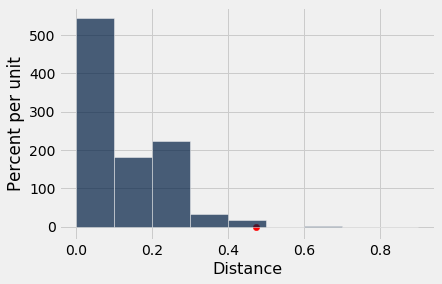

In [26]:
Table().with_column('Distance', distances).hist(bins = np.arange(0, 1, 0.1))
plots.scatter(observed_distance, 0, color='red', s=40);

In [27]:
np.average(distances >= observed_distance)

0.0070000000000000001

## Deflategate ##

In [28]:
football = Table.read_table('deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


In [29]:
combined = (football.column('Blakeman')+football.column('Prioleau'))/2
football = football.drop('Blakeman', 'Prioleau').with_column(
    'Combined', 
    combined)
football.show()

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


In [30]:
np.ones(5)

array([ 1.,  1.,  1.,  1.,  1.])

In [31]:
initial_pressure = np.append(12.5 * np.ones(11), 13 * np.ones(4))
initial_pressure

array([ 12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,
        12.5,  12.5,  13. ,  13. ,  13. ,  13. ])

In [32]:
drop_values = initial_pressure - football.column(1)

In [33]:
football = football.drop('Combined').with_column('Drop', drop_values)

In [34]:
football.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [35]:
means = football.group('Team', np.average)
means

Team,Drop average
Colts,0.46875
Patriots,1.20227


In [36]:
observed_difference = means.column(1).item(0) - means.column(1).item(1)
observed_difference

-0.733522727272728

In [37]:
def diff_between_means(tbl):
    means = tbl.group('Team', np.average).column(1)
    return means.item(0) - means.item(1)

In [38]:
drops = football.select('Drop')

In [39]:
shuffled_drops = drops.sample(with_replacement = False).column(0)
shuffled_drops

array([ 1.475,  1.175,  1.65 ,  1.35 ,  0.65 ,  0.85 ,  0.725,  0.425,
        0.475,  1.375,  1.8  ,  1.225,  0.475,  0.275,  1.175])

In [40]:
simulated_football = football.with_column('Drop', shuffled_drops)
simulated_football.show(3)

Team,Drop
Patriots,1.475
Patriots,1.175
Patriots,1.65


In [41]:
diff_between_means(simulated_football)

-0.2988636363636359

In [ ]:
differences = make_array()

for i in np.arange(5000):
    shuffled_drops = drops.sample(with_replacement = False).column(0)
    simulated_football = football.with_column('Drop', shuffled_drops)
    new_diff = diff_between_means(simulated_football)
    differences = np.append(differences, new_diff)

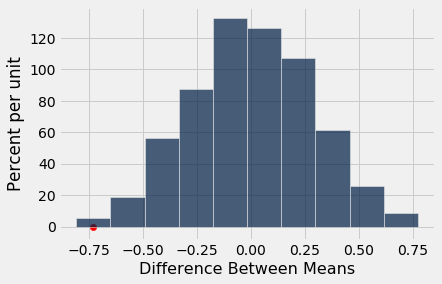

In [43]:
Table().with_column('Difference Between Means', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=40);

In [46]:
np.average(differences <= observed_difference)

0.0032000000000000002